In [1]:
import torch
import torchvision
import os
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader
import random
import os

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
# Transformações para normalização e aumento de dados (caso necessário)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
# Diretórios de treino e validação
train_dir = r"C:\Users\maste\OneDrive\Documentos\Artigo_Rita_Dataset_W\Training"
val_dir = r"C:\Users\maste\OneDrive\Documentos\Artigo_Rita_Dataset_W\Validation"

def contar_imagens(diretorio):
    contador = 0
    for root, dirs, files in os.walk(diretorio):
        contador += len([f for f in files if f.endswith(('.png', '.jpg', '.jpeg'))])
    return contador

num_treino = contar_imagens(train_dir)
num_validacao = contar_imagens(val_dir)

print(f'Número de imagens no dataset de treino: {num_treino}')
print(f'Número de imagens no dataset de validação: {num_validacao}')

Número de imagens no dataset de treino: 684
Número de imagens no dataset de validação: 147


In [7]:
# Carregando datasets de treino e validação
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

In [9]:
# Criando dataloaders para iterar sobre os dados durante o treinamento
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [11]:
# Definindo as classes do dataset
classes = train_data.classes
classes2 = val_data.classes
print(classes)
print(classes2)

['malignant_tumor', 'no_tumor']
['malignant_tumor', 'no_tumor']


In [13]:
# Carregando a SqueezeNet1_0 pré-treinada
model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)

In [15]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

# Ajustar a última camada para o número de classes
num_classes = len(classes)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
for param in model.classifier[1].parameters():
    param.requires_grad = True

# Adicionar função de ativação softmax no forward (opcional)
model.num_classes = num_classes

In [17]:
# Definindo a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Caminhos para salvar os pesos e o modelo
save_weights = r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo"
save_model = r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\melhor_modelo.pt"

In [23]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
torch.cuda.empty_cache()

In [31]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [33]:
model.to(device)
num_epochs=50
# Listas para armazenar perda e acurácia
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Listas para armazenar rótulos verdadeiros e predições para a matriz de confusão e curva ROC
all_labels = []
all_preds = []

# Treinamento e coleta de dados
best_accuracy = 0.0
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    train_loss_values.append(epoch_loss)
    train_accuracy_values.append(train_accuracy)

    # Validação
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        val_loss_values.append(val_loss)
        val_accuracy_values.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        scheduler.step()

        # Verificar se a acurácia de validação melhorou e salvar o modelo
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            model_save_path = os.path.join(save_weights, f'model_epoch_{epoch+1}_val_accuracy_{val_accuracy:.4f}.pt')
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved model at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f} to {model_save_path}')

print('Treinamento finalizado')

# Salvar o modelo inteiro
torch.save(model, save_model)
print(f'Saved entire model at {save_model}')

Validation Epoch 1/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01batch/s]


Epoch 1/50, Training Loss: 0.5905, Training Accuracy: 0.8041, Validation Loss: 0.4011, Validation Accuracy: 0.8639
Saved model at epoch 1 with validation accuracy: 0.8639 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_1_val_accuracy_0.8639.pt


Validation Epoch 2/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03batch/s]


Epoch 2/50, Training Loss: 0.1844, Training Accuracy: 0.9327, Validation Loss: 0.1861, Validation Accuracy: 0.9388
Saved model at epoch 2 with validation accuracy: 0.9388 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_2_val_accuracy_0.9388.pt


Validation Epoch 3/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09batch/s]


Epoch 3/50, Training Loss: 0.0999, Training Accuracy: 0.9561, Validation Loss: 0.1280, Validation Accuracy: 0.9728
Saved model at epoch 3 with validation accuracy: 0.9728 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_3_val_accuracy_0.9728.pt


Validation Epoch 4/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 4/50, Training Loss: 0.0818, Training Accuracy: 0.9722, Validation Loss: 0.0685, Validation Accuracy: 1.0000
Saved model at epoch 4 with validation accuracy: 1.0000 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_4_val_accuracy_1.0000.pt


Validation Epoch 5/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01batch/s]


Epoch 5/50, Training Loss: 0.0678, Training Accuracy: 0.9737, Validation Loss: 0.0455, Validation Accuracy: 1.0000


Validation Epoch 6/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/batch]


Epoch 6/50, Training Loss: 0.0616, Training Accuracy: 0.9693, Validation Loss: 0.0488, Validation Accuracy: 1.0000


Validation Epoch 7/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 7/50, Training Loss: 0.0360, Training Accuracy: 0.9868, Validation Loss: 0.0287, Validation Accuracy: 0.9864


Validation Epoch 8/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13batch/s]


Epoch 8/50, Training Loss: 0.0312, Training Accuracy: 0.9883, Validation Loss: 0.0271, Validation Accuracy: 0.9864


Validation Epoch 9/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11batch/s]


Epoch 9/50, Training Loss: 0.0201, Training Accuracy: 0.9956, Validation Loss: 0.0171, Validation Accuracy: 1.0000


Validation Epoch 10/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10batch/s]


Epoch 10/50, Training Loss: 0.0156, Training Accuracy: 0.9971, Validation Loss: 0.0144, Validation Accuracy: 1.0000


Validation Epoch 11/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08batch/s]


Epoch 11/50, Training Loss: 0.0131, Training Accuracy: 0.9985, Validation Loss: 0.0109, Validation Accuracy: 1.0000


Validation Epoch 12/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25batch/s]


Epoch 12/50, Training Loss: 0.0158, Training Accuracy: 0.9956, Validation Loss: 0.0161, Validation Accuracy: 1.0000


Validation Epoch 13/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06batch/s]


Epoch 13/50, Training Loss: 0.0147, Training Accuracy: 0.9956, Validation Loss: 0.0101, Validation Accuracy: 1.0000


Validation Epoch 14/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 14/50, Training Loss: 0.0124, Training Accuracy: 0.9971, Validation Loss: 0.0107, Validation Accuracy: 1.0000


Validation Epoch 15/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03batch/s]


Epoch 15/50, Training Loss: 0.0086, Training Accuracy: 0.9985, Validation Loss: 0.0097, Validation Accuracy: 1.0000


Validation Epoch 16/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 16/50, Training Loss: 0.0095, Training Accuracy: 0.9971, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 17/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 17/50, Training Loss: 0.0082, Training Accuracy: 0.9971, Validation Loss: 0.0085, Validation Accuracy: 1.0000


Validation Epoch 18/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 18/50, Training Loss: 0.0055, Training Accuracy: 0.9985, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 19/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09batch/s]


Epoch 19/50, Training Loss: 0.0057, Training Accuracy: 1.0000, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 20/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02batch/s]


Epoch 20/50, Training Loss: 0.0072, Training Accuracy: 1.0000, Validation Loss: 0.0079, Validation Accuracy: 1.0000


Validation Epoch 21/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 21/50, Training Loss: 0.0079, Training Accuracy: 0.9971, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 22/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09batch/s]


Epoch 22/50, Training Loss: 0.0085, Training Accuracy: 0.9971, Validation Loss: 0.0076, Validation Accuracy: 1.0000


Validation Epoch 23/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/batch]


Epoch 23/50, Training Loss: 0.0059, Training Accuracy: 0.9985, Validation Loss: 0.0077, Validation Accuracy: 1.0000


Validation Epoch 24/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15batch/s]


Epoch 24/50, Training Loss: 0.0123, Training Accuracy: 0.9956, Validation Loss: 0.0084, Validation Accuracy: 1.0000


Validation Epoch 25/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08batch/s]


Epoch 25/50, Training Loss: 0.0055, Training Accuracy: 1.0000, Validation Loss: 0.0089, Validation Accuracy: 1.0000


Validation Epoch 26/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13batch/s]


Epoch 26/50, Training Loss: 0.0080, Training Accuracy: 1.0000, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 27/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09batch/s]


Epoch 27/50, Training Loss: 0.0081, Training Accuracy: 0.9956, Validation Loss: 0.0081, Validation Accuracy: 1.0000


Validation Epoch 28/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/batch]


Epoch 28/50, Training Loss: 0.0075, Training Accuracy: 0.9985, Validation Loss: 0.0088, Validation Accuracy: 1.0000


Validation Epoch 29/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10batch/s]


Epoch 29/50, Training Loss: 0.0043, Training Accuracy: 1.0000, Validation Loss: 0.0088, Validation Accuracy: 1.0000


Validation Epoch 30/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 30/50, Training Loss: 0.0075, Training Accuracy: 0.9985, Validation Loss: 0.0085, Validation Accuracy: 1.0000


Validation Epoch 31/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34batch/s]


Epoch 31/50, Training Loss: 0.0087, Training Accuracy: 0.9985, Validation Loss: 0.0084, Validation Accuracy: 1.0000


Validation Epoch 32/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37batch/s]


Epoch 32/50, Training Loss: 0.0078, Training Accuracy: 0.9985, Validation Loss: 0.0082, Validation Accuracy: 1.0000


Validation Epoch 33/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11batch/s]


Epoch 33/50, Training Loss: 0.0052, Training Accuracy: 1.0000, Validation Loss: 0.0081, Validation Accuracy: 1.0000


Validation Epoch 34/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 34/50, Training Loss: 0.0068, Training Accuracy: 0.9985, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 35/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04batch/s]


Epoch 35/50, Training Loss: 0.0046, Training Accuracy: 1.0000, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 36/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01batch/s]


Epoch 36/50, Training Loss: 0.0084, Training Accuracy: 0.9971, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 37/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03batch/s]


Epoch 37/50, Training Loss: 0.0072, Training Accuracy: 0.9985, Validation Loss: 0.0079, Validation Accuracy: 1.0000


Validation Epoch 38/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04batch/s]


Epoch 38/50, Training Loss: 0.0067, Training Accuracy: 1.0000, Validation Loss: 0.0077, Validation Accuracy: 1.0000


Validation Epoch 39/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 39/50, Training Loss: 0.0111, Training Accuracy: 0.9956, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 40/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08batch/s]


Epoch 40/50, Training Loss: 0.0088, Training Accuracy: 0.9985, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 41/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02batch/s]


Epoch 41/50, Training Loss: 0.0045, Training Accuracy: 1.0000, Validation Loss: 0.0080, Validation Accuracy: 1.0000


Validation Epoch 42/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04batch/s]


Epoch 42/50, Training Loss: 0.0045, Training Accuracy: 1.0000, Validation Loss: 0.0079, Validation Accuracy: 1.0000


Validation Epoch 43/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 43/50, Training Loss: 0.0052, Training Accuracy: 1.0000, Validation Loss: 0.0079, Validation Accuracy: 1.0000


Validation Epoch 44/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04batch/s]


Epoch 44/50, Training Loss: 0.0069, Training Accuracy: 0.9971, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 45/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02batch/s]


Epoch 45/50, Training Loss: 0.0062, Training Accuracy: 1.0000, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 46/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02batch/s]


Epoch 46/50, Training Loss: 0.0075, Training Accuracy: 0.9985, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 47/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04batch/s]


Epoch 47/50, Training Loss: 0.0054, Training Accuracy: 1.0000, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 48/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01batch/s]


Epoch 48/50, Training Loss: 0.0052, Training Accuracy: 1.0000, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 49/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03batch/s]


Epoch 49/50, Training Loss: 0.0080, Training Accuracy: 0.9985, Validation Loss: 0.0078, Validation Accuracy: 1.0000


Validation Epoch 50/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06batch/s]

Epoch 50/50, Training Loss: 0.0076, Training Accuracy: 0.9971, Validation Loss: 0.0078, Validation Accuracy: 1.0000
Treinamento finalizado
Saved entire model at C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\melhor_modelo.pt


In [35]:
save_model = r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\melhor_modelo.pt"
model = torch.load(save_model, weights_only=False)
model.eval()
print(f'Loaded model from {save_model}')

model_save_path= r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_4_val_accuracy_1.0000.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()
print(f'Loaded weights from {model_save_path}')

Loaded model from C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\melhor_modelo.pt
Loaded weights from C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_4_val_accuracy_1.0000.pt


C:\Users\maste\AppData\Local\Temp\ipykernel_29772\2422150870.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


In [37]:
# Confirmação do carregamento do modelo e dos pesos
model.to(device)

model.eval()
confirmation_correct = 0
confirmation_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        confirmation_total += labels.size(0)
        confirmation_correct += (predicted == labels).sum().item()

print(f'Confirmation Accuracy: { confirmation_correct / confirmation_total:.4f}')

Confirmation Accuracy: 1.0000


In [39]:
# Avaliando o modelo carregado no conjunto de validação
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

all_labels = []
all_probs = []  # Para armazenar as probabilidades

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Val"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #loss = nn.CrossEntropyLoss()(outputs, labels)
        #test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        # Armazenando rótulos e probabilidades
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]

Val Loss: 0.0078, Val Accuracy: 1.0000


In [41]:
# Calculando a matriz de confusão
cm = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))

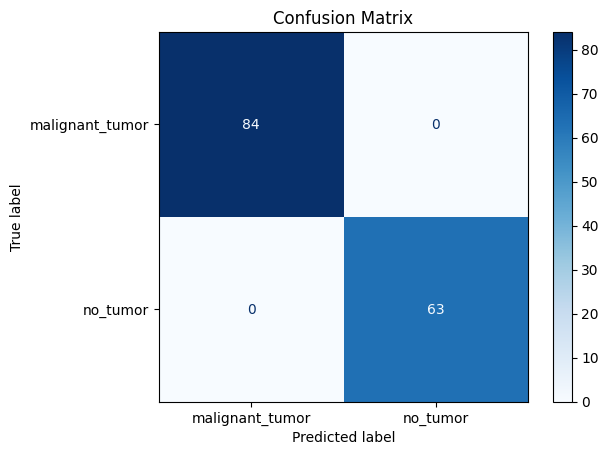

In [43]:
# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\gráficos\treino\Matriz_treino.pdf")
plt.show()

In [45]:
import torch
from sklearn.metrics import classification_report
#from  utils import to_onehot
# Alterar o modelo para o modo de avaliação
model.eval()

# Para armazenar rótulos verdadeiros e previsões
all_labels = []
all_preds = []

# Desabilitar cálculo de gradiente para inferência
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Obter saídas do modelo e prever a classe
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Armazenar rótulos e previsões
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
#all_preds = utils.to_onehot(all_probs, 1)
# Gerar relatório de classificação
target_names = ['Câncer', 'Normal']
print(classification_report(all_labels, all_preds, target_names=target_names))
print(outputs)
print(preds)
print(all_preds)

              precision    recall  f1-score   support

      Câncer       1.00      1.00      1.00        84
      Normal       1.00      1.00      1.00        63

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147

tensor([[0.1554, 4.2050],
        [0.2664, 2.6740],
        [0.1363, 4.6115],
        [0.0000, 5.8611],
        [0.1430, 3.1765],
        [0.1960, 3.2596],
        [0.1668, 3.2605],
        [0.0749, 3.1152],
        [0.4713, 4.0466],
        [0.4044, 3.5171],
        [1.1282, 2.6597],
        [0.7200, 2.7514],
        [0.1367, 3.9791],
        [0.2403, 3.5587],
        [0.2242, 3.6853],
        [0.0000, 4.4079],
        [1.2943, 3.5637],
        [0.4498, 5.7842],
        [0.1442, 5.8596]], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.in

In [47]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
#y_pred_keras = keras_model.predict(X_test).ravel()


classes = val_data.classes
num_classes = len(classes)

all_labels = np.array(all_labels)
all_preds = np.array( all_preds)

fpr, tpr, _ = roc_curve(all_labels , all_preds)

print(fpr)
print('---------')
print(tpr)
print('---------')




#for i in range(num_classes):
#    # Calculando a ROC para a classe i
#    fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, label=f'Classe {classes[i]} (AUC = {roc_auc:.2f})')

[0. 0. 1.]
---------
[0. 1. 1.]
---------


In [49]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
print(auc_keras)

1.0


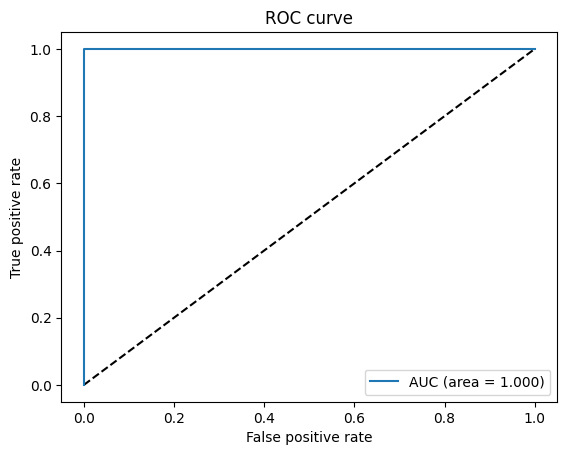

In [51]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\gráficos\treino\CurvaRoc_treino.pdf")
plt.show()

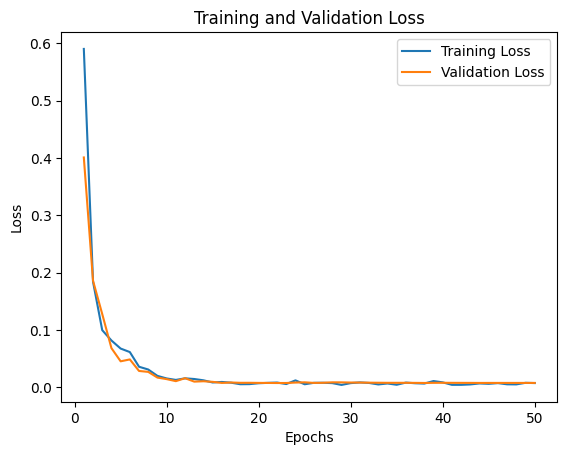

In [53]:
# Plotando a perda
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\gráficos\treino\Loss_treino.pdf")
plt.show()

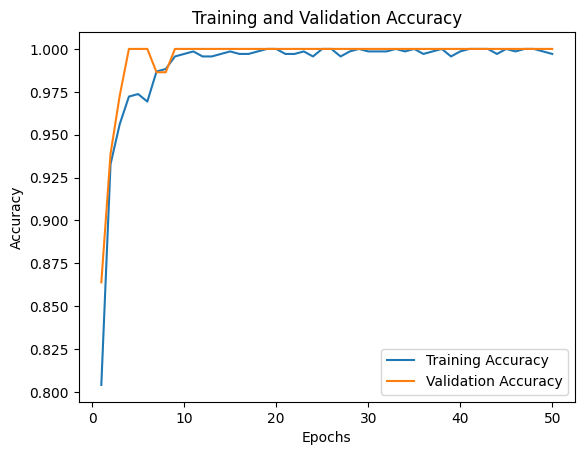

In [55]:
# Plotando a acurácia
plt.figure()
plt.plot(epochs, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig(r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\gráficos\treino\Accuracy_treino.pdf")
plt.show()

In [57]:
test_dir = r"C:\Users\maste\OneDrive\Documentos\Artigo_Rita_Dataset_W\Testing"

In [59]:
# Transformações para normalização e aumento de dados
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [61]:
test_data = datasets.ImageFolder(test_dir, transform=transform)

In [63]:
# Criando o DataLoader para o conjunto de teste
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [65]:
# Definindo as classes do dataset
classes = test_data.classes
num_classes = len(classes)
print(num_classes)
print(classes)

2
['malignant_tumor', 'no_tumor']


In [67]:
# Avaliando o modelo carregado no conjunto de teste
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

all_labels = []
all_probs = []  # Para armazenar as probabilidades

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #loss = nn.CrossEntropyLoss()(outputs, labels)
        #test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Armazenando rótulos e probabilidades
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    test_loss = val_running_loss / len(test_loader.dataset)
    test_accuracy = test_correct / test_total
    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}')

Test: 100%|██████████████████████████████████████████████████████████████████████████| 146/146 [00:06<00:00, 22.66it/s]

Val Loss: 0.0079, Val Accuracy: 0.9110


In [69]:
# Calculando a matriz de confusão
cm = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))

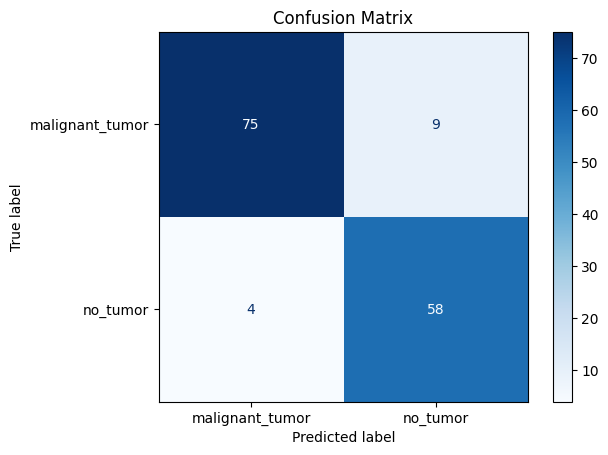

In [71]:
# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\gráficos\validação\Matriz_validação.pdf")
plt.show()

In [73]:
import torch
from sklearn.metrics import classification_report
#from  utils import to_onehot
# Alterar o modelo para o modo de avaliação
model.eval()

# Para armazenar rótulos verdadeiros e previsões
all_labels = []
all_preds = []

# Desabilitar cálculo de gradiente para inferência
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Obter saídas do modelo e prever a classe
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Armazenar rótulos e previsões
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
#all_preds = utils.to_onehot(all_probs, 1)
# Gerar relatório de classificação
target_names = ['Câncer', 'Normal']
print(classification_report(all_labels, all_preds, target_names=target_names))
print(outputs)
print(preds)
print(all_preds)

              precision    recall  f1-score   support

      Câncer       0.95      0.89      0.92        84
      Normal       0.87      0.94      0.90        62

    accuracy                           0.91       146
   macro avg       0.91      0.91      0.91       146
weighted avg       0.91      0.91      0.91       146

tensor([[ 0.0948, 11.8115]], device='cuda:0')
tensor([1], device='cuda:0')
[np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0),

In [74]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
#y_pred_keras = keras_model.predict(X_test).ravel()


classes = test_data.classes
num_classes = len(classes)

all_labels = np.array(all_labels)
all_preds = np.array( all_preds)

fpr, tpr, _ = roc_curve(all_labels , all_preds)

print(fpr)
print('---------')
print(tpr)
print('---------')

[0.         0.10714286 1.        ]
---------
[0.         0.93548387 1.        ]
---------


In [77]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
print(auc_keras)

0.9141705069124425


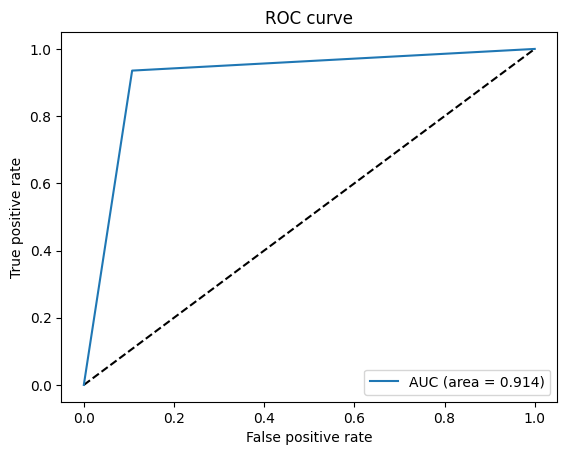

In [79]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\gráficos\validação\CurvaRoc_validação.pdf")
plt.show()

In [3]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import squeezenet1_0

# --------- Pré-processamento ---------
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # SqueezeNet usa 224x224
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])(img)
    img_tensor = img.unsqueeze(0)
    return img_tensor

# --------- Pegando a camada da CNN ---------
def get_conv_layer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    raise ValueError(f"Camada '{conv_layer_name}' não encontrada.")

# --------- Grad-CAM tradicional ---------
def compute_gradcam(model, img_tensor, class_index, conv_layer_name="features.12"):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    conv_layer = get_conv_layer(model, conv_layer_name)
    forward_handle = conv_layer.register_forward_hook(forward_hook)
    backward_handle = conv_layer.register_backward_hook(backward_hook)

    model.zero_grad()
    output = model(img_tensor)
    loss = output[:, class_index]
    loss.backward()

    forward_handle.remove()
    backward_handle.remove()

    act = activations[0].squeeze(0).detach().cpu().numpy()
    grad = gradients[0].squeeze(0).detach().cpu().numpy()

    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / (np.max(cam) + 1e-8)
    return cam

# --------- Grad-CAM++ ---------
def compute_gradcam_plus(model, img_tensor, class_index, conv_layer_name="features.12"):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    conv_layer = get_conv_layer(model, conv_layer_name)
    forward_handle = conv_layer.register_forward_hook(forward_hook)
    backward_handle = conv_layer.register_backward_hook(backward_hook)

    model.zero_grad()
    output = model(img_tensor)
    loss = output[:, class_index]
    loss.backward(retain_graph=True)

    forward_handle.remove()
    backward_handle.remove()

    act = activations[0].squeeze(0)  # [C, H, W]
    grad = gradients[0].squeeze(0)   # [C, H, W]

    grads_power_2 = grad ** 2
    grads_power_3 = grad ** 3
    sum_activations = torch.sum(act, dim=(1, 2), keepdim=True)

    alpha_num = grads_power_2
    alpha_denom = 2 * grads_power_2 + sum_activations * grads_power_3
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

    alphas = alpha_num / alpha_denom
    weights = (alphas * torch.relu(grad)).sum(dim=(1, 2))

    cam = torch.zeros(act.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = cam.detach().cpu().numpy()
    cam[cam < 0.3] = 0
    
    return cam

# --------- Sobrepor Heatmap ---------
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

# --------- Anotar a imagem com porcentagens ---------
def annotate_image(image, probs, class_names):
    annotated = image.copy()
    for i, (name, prob) in enumerate(zip(class_names, probs)):
        text = f"{name}: {prob * 100:.1f}%"
        cv2.putText(annotated, text, (10, 30 + i * 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    return annotated

# --------- Principal ---------
if __name__ == "__main__":
    # Carregando modelo SqueezeNet treinado com 2 classes
    model = squeezenet1_0(weights=None)
    model.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
    model.num_classes = 2
    model.load_state_dict(torch.load(
        r"C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\Wavelet\SqueezeNet_1_0\50_epocas\SGD\melhor_modelo\model_epoch_4_val_accuracy_1.0000.pt",
        map_location="cpu"))
    model.eval()

    # Caminho da imagem
    img_path = r"C:\Users\maste\OneDrive\Documentos\Artigo_Rita_Dataset_W\Testing\malignant_tumor\resultado_GaussianoMalignant case (399)_dmey.png"
    img_tensor = preprocess_image(img_path)

    # Obter predições e probabilidades
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1)
        class_index = torch.argmax(probs, dim=1).item()

    print(f"Índice da Classe Predita: {class_index}")

    class_names = ["Cancer", "Normal"]
    class_probs = probs[0].cpu().numpy()

    # --------- Grad-CAM Tradicional ---------
    heatmap_trad = compute_gradcam(model, img_tensor, class_index, conv_layer_name="features.12")
    output_img_trad = overlay_heatmap(img_path, heatmap_trad)
    output_img_trad = annotate_image(output_img_trad, class_probs, class_names)
    cv2.imwrite(r"C:\Users\maste\OneDrive\Documentos\saida\SqueezeNet\Test3_trad.jpg", output_img_trad)

    # --------- Grad-CAM++ ---------
    heatmap_plus = compute_gradcam_plus(model, img_tensor, class_index, conv_layer_name="features.12")
    output_img_plus = overlay_heatmap(img_path, heatmap_plus)
    output_img_plus = annotate_image(output_img_plus, class_probs, class_names)
    cv2.imwrite(r"C:\Users\maste\OneDrive\Documentos\saida\SqueezeNet\Test4_plus.jpg", output_img_plus)


C:\Users\maste\AppData\Local\Temp\ipykernel_5280\1066392798.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


Índice da Classe Predita: 0
